# Introduction to Data Science project "Pump It Up"

- Nikolay Kalmykov
- Damir Akhmetov
- Ivan Safonov

# 1. The problem

According to [water.org](https://water.org), 4 million people in Tanzania lack access to an improved source of safe water. 

People living under these circumstances spend a significant amount of time traveling long distances to collect water from waterpoints.

Accurate prediction whether the pumps are functional or not is really important because people are at risk of health deterioration or even death from dehydration. 

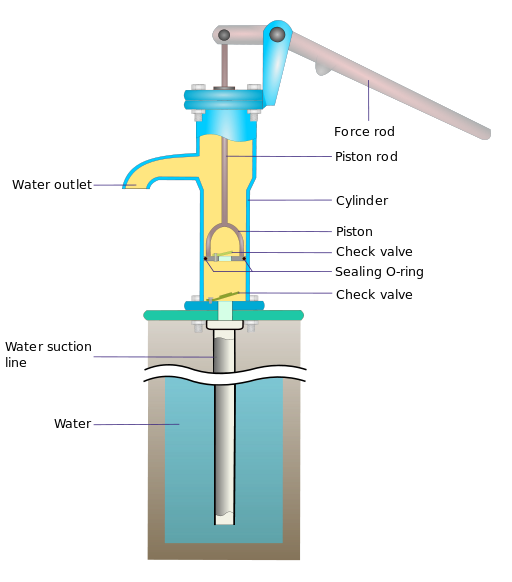

Using data from Taarifa and the Tanzanian Ministry of Water, we should predict which pumps are functional, which need some repairs, and which don't work at all. The prediction will be based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

[Link to the competition](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table)

# 2. Data loading

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
X = pd.read_csv("X_data.csv", index_col=0)
y = pd.read_csv("y_data.csv", index_col=0)
assert (X.index == y.index).all()
X_pred = pd.read_csv("X_pred.csv", index_col=0)

Let's look at our dataset

In [3]:
pd.options.display.max_columns = 41
X.head(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


There are $39$ features.

Let's find:

- How many samples in train/prediction dataset.
- How many numeric, categorial features we have.

In [4]:
print(f"train shape: {X.shape}")
print(f"label shape: {y.shape}")
print(f"pred shape: {X_pred.shape}")

cat_features = 0
numeric_features = 0

for column, tp in X.dtypes.items():
    if str(tp) == 'object':
        cat_features += 1
    else:
        numeric_features += 1

print(f'\nThere are {cat_features} categorial features and {numeric_features} numeric features.')

train shape: (59400, 39)
label shape: (59400, 1)
pred shape: (14850, 39)

There are 30 categorial features and 9 numeric features.


Most of our features are categorial.

Let's find all N/A values and deal with them.

In [5]:
y.isna().sum()

status_group    0
dtype: int64

In [6]:
nan_count = X.isna().sum()
for column, cnt in nan_count.items():
    if cnt > 0:
        dtype = str(X.dtypes[column])
        print(f'{column}, dtype={dtype}, count={cnt}')

funder, dtype=object, count=3635
installer, dtype=object, count=3655
subvillage, dtype=object, count=371
public_meeting, dtype=object, count=3334
scheme_management, dtype=object, count=3877
scheme_name, dtype=object, count=28166
permit, dtype=object, count=3056


All of them are in categorial columns, so let's replace all N/A values with `None` string.

In [7]:
X.fillna(value="None", inplace=True)
X_pred.fillna(value="None", inplace=True)

We have a classification problem.

We should find what class the waterpoint belongs to:

1. `functional`
2. `non functional`
3. `functional needs repair`

Let's encode string labels with numbers 0/1/2

In [8]:
y["status_group"].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [9]:
class_labels = [
    "functional",
    "non functional",
    "functional needs repair"
]

label_to_id = {class_labels[i]: i for i in range(len(class_labels))}

In [10]:
y["class"] = y["status_group"].apply(lambda x: label_to_id[x])

Let's convert all `object` columns (which are categorial) into `string` columns:

In [11]:
dtypes = X.dtypes
for column, tp in dtypes.items():
    if str(tp) == 'object':
        X[column] = pd.Series(X[column], dtype="string")

# 3. Exploratory analysis

In [12]:
df = pd.concat([y[["status_group"]], X], axis = 1)

In [13]:
font = {'size'   : 30}
plt.rc('font', **font)

### How many waterpoints are there? Are they permitted?

In [14]:
df['permit'] = df.permit.apply(lambda x: 'Yes' if x == 'True' else 'No')
df_cross = (pd.crosstab(df.status_group, df.permit) / len(df)) * 100
df_cross["Total"] = df_cross.No + df_cross.Yes
df_cross

permit,No,Yes,Total
status_group,,,
functional,18.043771,36.264310,54.308081
functional needs repair,2.727273,4.540404,7.267677
non functional,13.821549,24.602694,38.424242


There are 55% `functional`, 38% of `non functional` and 7% of `functional needs repair` waterpoints. Also, about half of them are installed without permission.

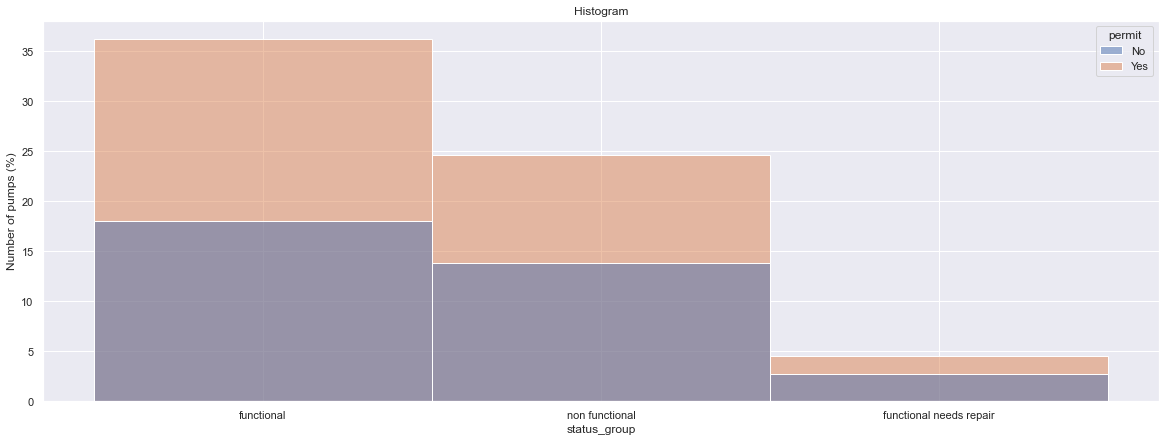

In [15]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.histplot(data=df, x="status_group", hue="permit", stat='percent');
plt.ylabel('Number of pumps (%)');
plt.title('Histogram');

### Look at the dependence of amount of water on payment

In [16]:
df.groupby('payment')['amount_tsh'].mean()

payment
never pay                   4.946552
other                     326.423150
pay annually             2514.448105
pay monthly               918.711446
pay per bucket             41.646928
pay when scheme fails     315.942770
unknown                     0.646684
Name: amount_tsh, dtype: float64

It is clear that people who regularly pay for water have more water comparing ones who not pay.

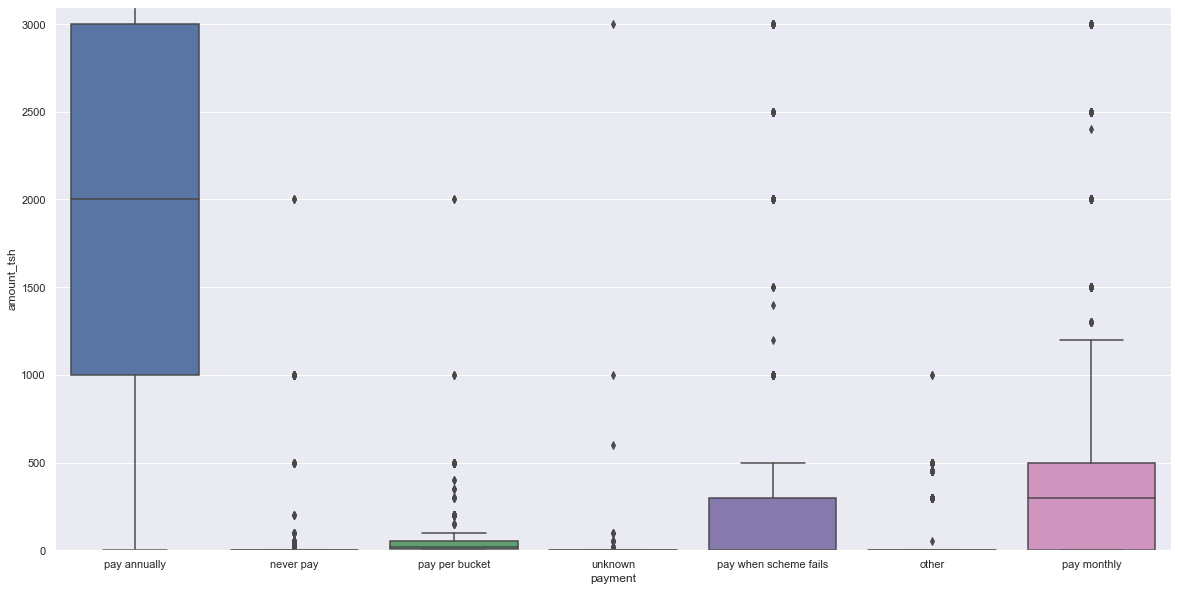

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = 'payment', y='amount_tsh', data = df);
plt.ylim(0, 3100);

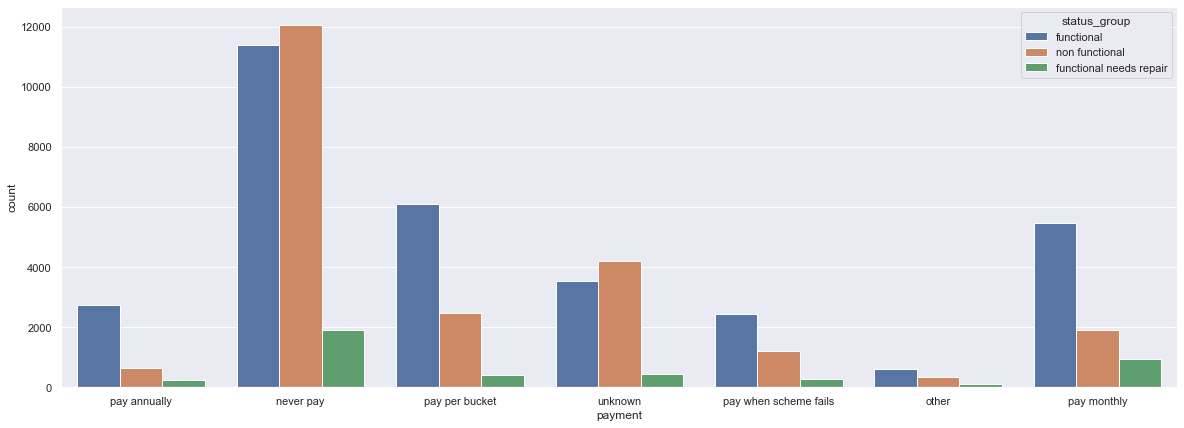

In [18]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.countplot(data=df, x="payment", hue="status_group");

It also works for waterpoints. If you pay for service then the probability that your waterpoint is functional will be higher.

### What is the main source used for waterpoints?

The most popular sources are `spring` and `shallow well`. In the first case, functional waterpoints prevail there and half of them are `non functional`. In the second, there are the same number of `functional` and `non functional` waterpoints.

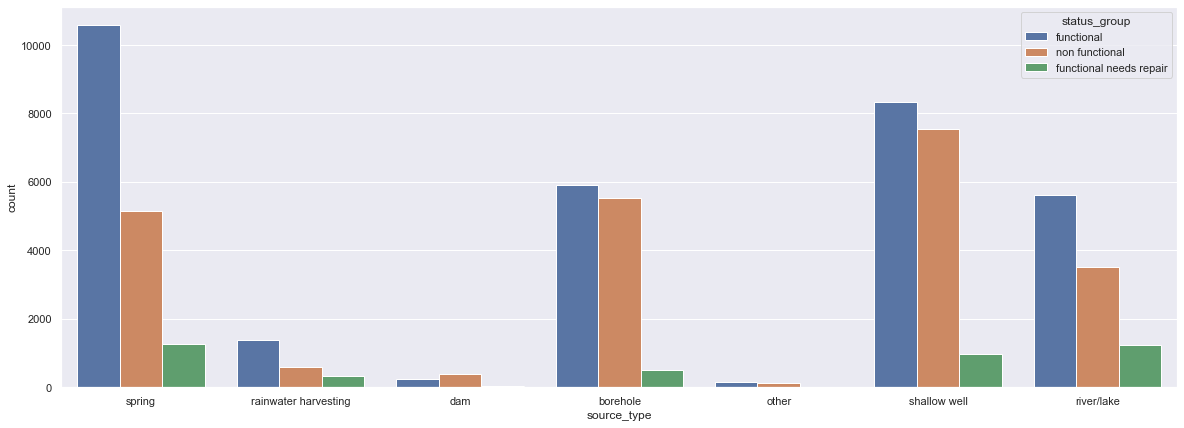

In [19]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.countplot(data=df, x="source_type", hue = "status_group");

The most popular watertype is `communal standpipe` and `hand pump`.

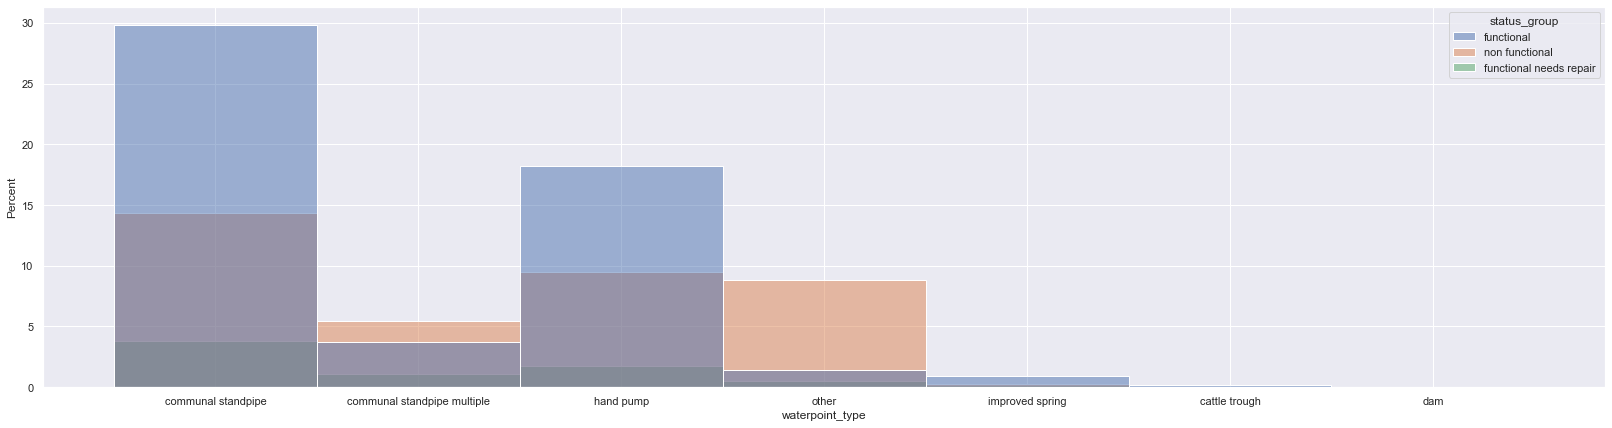

In [20]:
fig, ax = plt.subplots(figsize=(28, 7))
sns.histplot(data=df, x="waterpoint_type", hue="status_group", stat='percent');

### Dependence management on amount of water

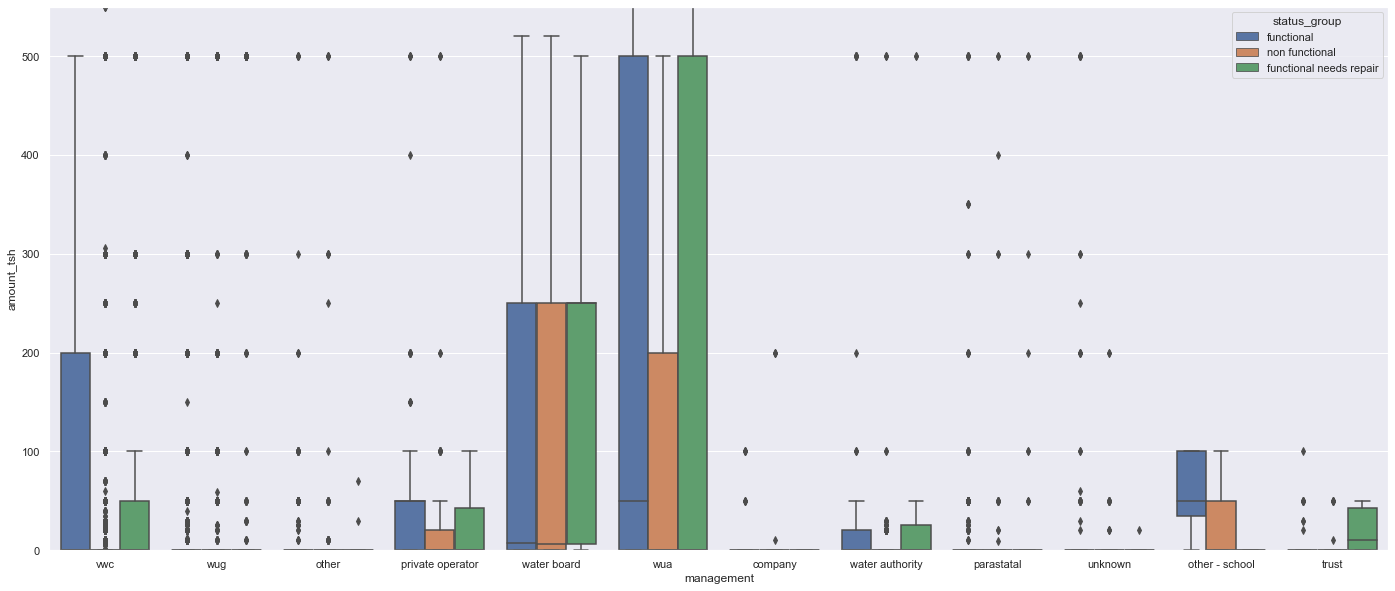

In [21]:
fig, ax = plt.subplots(figsize=(24, 10))

sns.boxplot(x='management', y='amount_tsh', hue='status_group', data = df);
plt.ylim(0,550);

It turns out that when managing companies `wua` and `water board`, the amount of water is the most.

### Dependence between numeric features

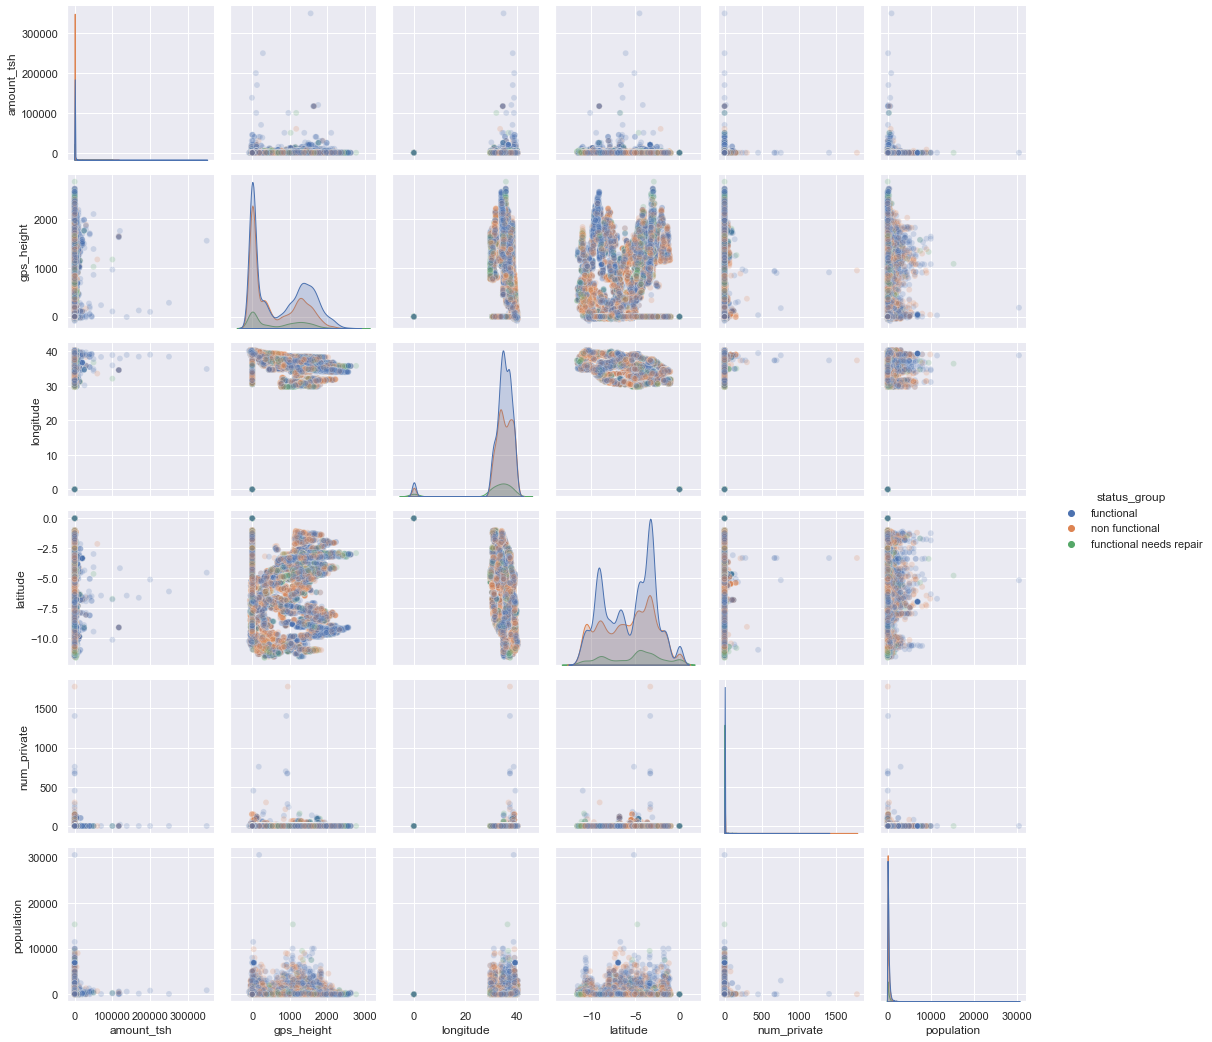

In [22]:
sns.pairplot(df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'status_group']],
             hue='status_group', kind='scatter', plot_kws=dict(alpha=0.2));

We can see, that for most of numeric features there are some outliers, so on the histogram we don't see a good distribution. We should be accurate with outliers during the train.

Let's remove them and plot again:

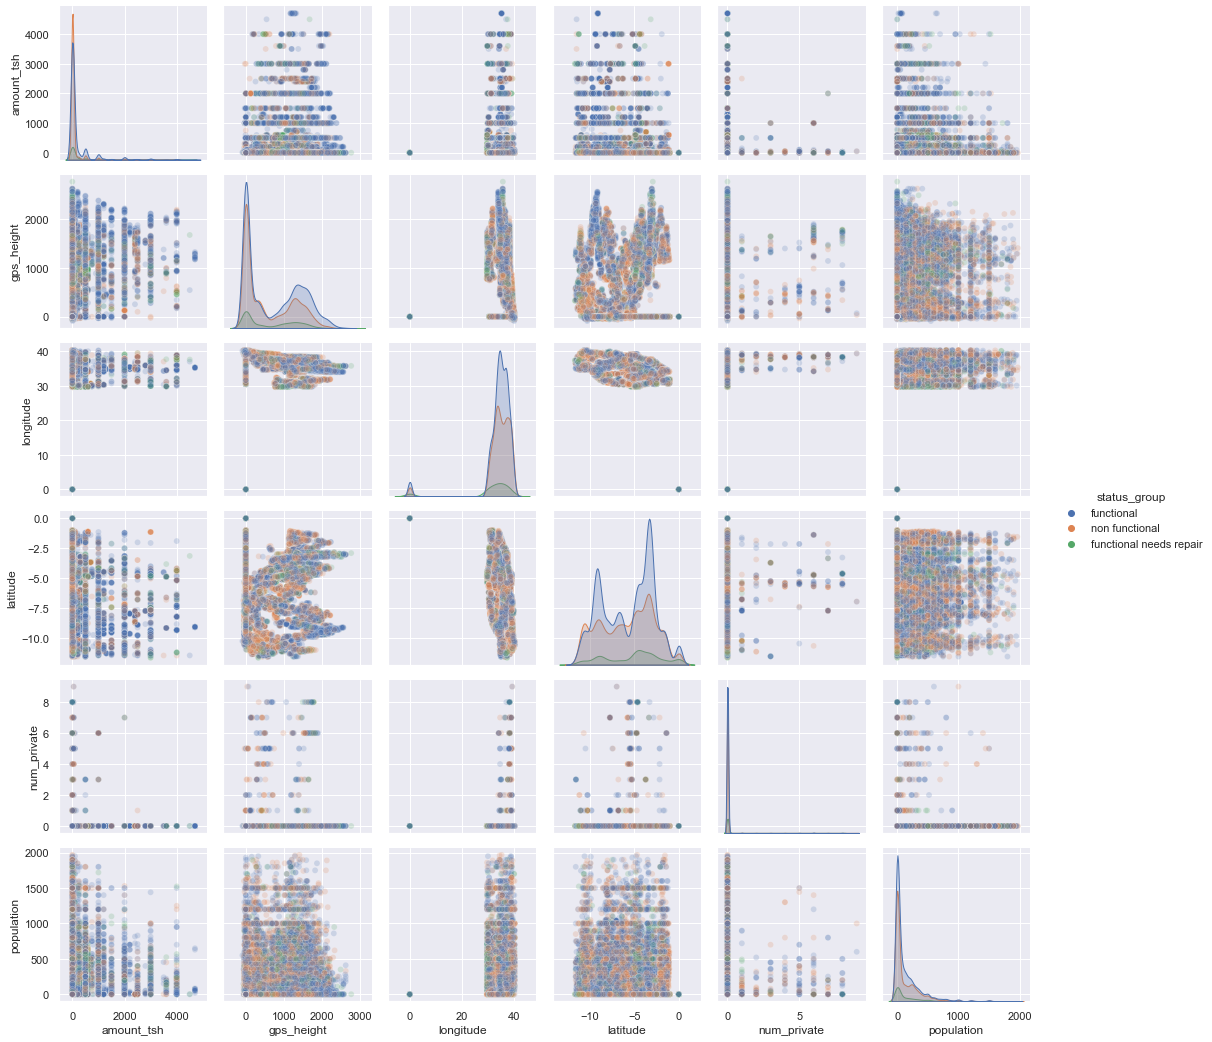

In [23]:
mask = (df['amount_tsh'] < 5000) & (df['num_private'] < 10) & (df['population'] < 2000)
sns.pairplot(df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'status_group']][mask],
             hue='status_group', kind='scatter', plot_kws=dict(alpha=0.2));

# 4. Default CatBoost train

Our dataset consists mainly of categorial features.

Before we start making some hard Data Science, let's just train a default CatBoost model (luckily we don't need to process features).

Let's check the model's score in the competition, if trained on the full dataset.

In [24]:
def train_full_dataset(model, X_train_c, y_train_c, X_pred_c, out_file="submit.csv"):
    model.fit(X_train_c, y_train_c)
    
    y_pred = model.predict(X_pred_c).squeeze()
    str_labels = list(map(lambda i: class_labels[i], y_pred))
    answer = pd.DataFrame({'id': X_pred.index, 'status_group': str_labels})
    answer.set_index('id', inplace=True)
    
    answer.to_csv(out_file)

In [25]:
from catboost import CatBoostClassifier

cat_features = []
for name, tp in X.dtypes.items():
    if str(tp) == "string":
        cat_features.append(name)

model = CatBoostClassifier(cat_features=cat_features, verbose=0)
train_full_dataset(model, X, y["class"].values, X_pred, "catboost_submit.csv")

ModuleNotFoundError: No module named 'catboost'

In the competition the simple `accuracy` metric is used to score the prediction.

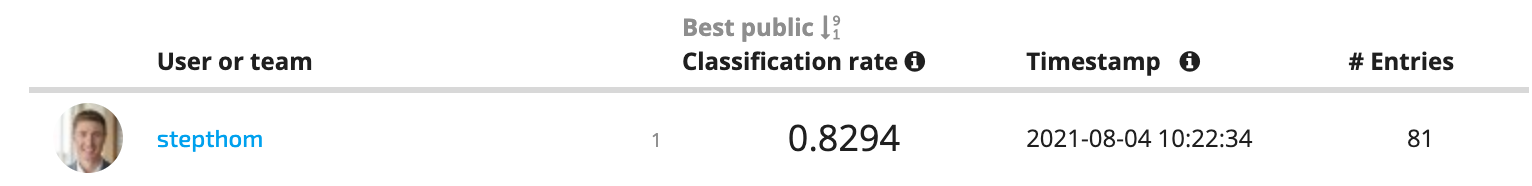

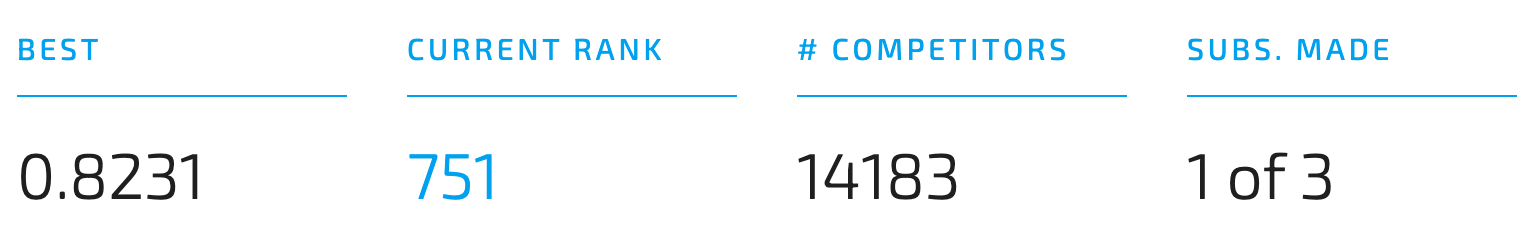

Wow! Enough to lose only 0.005 of accuracy to leader.

# 5. Data preparation

## 5.1 Metrics

Let's choose some metrics to evaluate the performance of our model.

We will calculate such metrics:

- `Accuracy`
- `Balanced accuracy`: accuracy of each class is multiplied by the frequency of this class
- `Confusion matrix`
- `F1 weighted`: average F1 score of each class vs rest, weighted with frequency of the class
- `AUC`: average AUC score of each class vs rest, weighted with frequency of the class
- `Weighted fine`: let's say, that the mistake, where we predict class `non functional` in case of true class `functional` (and vice versa) is twice more bad than other mistakes. This is because the class `functional needs repair` is between classes `functional` and `non functional`. So let's make a fine for each type of mistakes and calculate an average fine.

We think, that metrics `Balanced accuracy`, `F1 weighted`, `Weighted fine` are the main three metrics for our problem, because it is very important not only to predict the class correctly in average, but to predict each of the classes accurately (have good precision/recall for each class).

Also `Weighted fine` can be the most useful metric in real-world case, because each type of mistake made by the model can cost different number of money (or other resources), so it is more important for the model not to make one mistakes than another. In our case we invented some weights for mistakes, but in real-world case they can be estimated and used to select the best model.

In [26]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score


class ModelMetrics:
    def __init__(self, model, X, y, desc=''):
        y_pred = model.predict(X).squeeze()

        n = len(y)

        self.desc = desc
        self.accuracy = accuracy_score(y, y_pred)
        self.balanced_accuracy_score = balanced_accuracy_score(y, y_pred)
        self.confusion_matrix = confusion_matrix(y, y_pred)
        self.f1_weighted = f1_score(y, y_pred, average='weighted')
        
        self.auc = None
        prob = getattr(model, "predict_proba", None)
        if prob is not None and callable(prob):
            y_score = model.predict_proba(X)
            self.auc = roc_auc_score(y, y_score, average='weighted', multi_class='ovr')

        self.weighted_fine = self.confusion_matrix[0, 1] * 2 + self.confusion_matrix[0, 2]
        self.weighted_fine += self.confusion_matrix[1, 0] * 2 + self.confusion_matrix[1, 2]
        self.weighted_fine += self.confusion_matrix[2, 0] + self.confusion_matrix[2, 1]
        self.weighted_fine /= n

    def print(self):
        if len(self.desc) > 0:
            print(f'Metrics of "{self.desc}":')
        print(f'Accuracy: {self.accuracy:.3f} | ', end='')
        print(f'Balanced accuracy: {self.balanced_accuracy_score:.3f} | ', end='')
        print(f'F1(weighted): {self.f1_weighted:.3f} | ', end='')
        if self.auc is not None:
            print(f'AUC: {self.auc:.3f} | ', end='')
        print(f'Weighted fine: {self.weighted_fine:.3f}')
        print(f'Confusion matrix:\n{self.confusion_matrix}')
        
        if False:
            fig = plt.figure(figsize=(8, 6))
            disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=class_labels)
            disp.plot(xticks_rotation='vertical')
            plt.show()


training_log = []

            
def train_model(description, model, X_train, y_train, X_test, y_test, verbose=True):
    model.fit(X_train, y_train)
    
    train_metrics = ModelMetrics(model, X_train, y_train, description + " (train)")
    test_metrics = ModelMetrics(model, X_test, y_test, description + " (test)")
    
    global training_log
    training_log.append((description, train_metrics, test_metrics))

    if verbose:
        train_metrics.print()
        test_metrics.print()

    return model, train_metrics, test_metrics

## 5.2. Data split

To estimate the performance of our model we split the training dataset into train and test parts:

- The size of train is 80%
- The size of test is 20%

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=239, shuffle=True, stratify=y)
y_train = y_train["class"].values
y_test = y_test["class"].values

In [28]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (47520, 39)
y_train shape: (47520,)
X_test shape: (11880, 39)
y_test shape: (11880,)


Let's again train the default CatBoost model on our training dataset and estimate metrics on train and test datasets.

In [29]:
from catboost import CatBoostClassifier

cat_features = []
for name, tp in X.dtypes.items():
    if str(tp) == "string":
        cat_features.append(name)

catboost_model = CatBoostClassifier(cat_features=cat_features, verbose=0)
_, _, _ = train_model("CatBoost_default", catboost_model, X_train, y_train, X_test, y_test)

/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Metrics of "CatBoost_default (train)":
Accuracy: 0.883 | Balanced accuracy: 0.771 | F1(weighted): 0.879 | AUC: 0.968 | Weighted fine: 0.189
Confusion matrix:
[[24555  1011   241]
 [ 2422 15673   164]
 [ 1415   296  1743]]
Metrics of "CatBoost_default (test)":
Accuracy: 0.812 | Balanced accuracy: 0.658 | F1(weighted): 0.802 | AUC: 0.913 | Weighted fine: 0.312
Confusion matrix:
[[5830  519  103]
 [ 950 3564   51]
 [ 465  148  250]]


/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


## 5.3. Features transformation

We should drop/add some features, transform all our categorial and numeric features into real values to use them to train machine learning models.

Let's start with adding and dropping some features.

Features we add:

- `working_days`: the number of days, that pump are working.
- `year`, `month`, `weekday`: the year, month and weekday of recorded date. We can use the year, because we checked, that years in the train and prediction datasets are the same.
- `water_per_person`: the value equal to `amount_tsh`/max(10, `population`). The meaning: average number of water per person.
- `person_per_water`: the value equal to `population`/max(10, `amount_tsh`). The meaning: average number of people per 1 unit of water.

Features we drop:

- `date_recorded`: we used information about it
- `quantity_group`: there exists exactly the same column `quantity`
- `recorded_by`: all values in this column are the same

Also we have information about approximately the same columns (like `region`/`region_code`) or columns with approximately all values equal to $0$ (like `num_private`). But we tried to drop them and the quality became a bit smaller, so we decided not to drop them.

In [30]:
import datetime


def calculate_additional_features(X):
    X = X.copy()
    
    def calculate_working_days(row):
        if row[1] == 0:
            return 0
        date_recorded = datetime.datetime.strptime(row[0], "%Y-%m-%d").date()
        date_launched = datetime.datetime.strptime(f'{row[1]}-01-01', "%Y-%m-%d").date()
        return (date_recorded - date_launched).days
    X['working_days'] = X[['date_recorded', 'construction_year']].apply(calculate_working_days, axis=1)
    
    X['date'] = pd.to_datetime(X['date_recorded'])
    X['year'] = X.date.dt.year
    X['month'] = X.date.dt.month
    X['weekday'] = X.date.dt.weekday
    X.drop(labels=['date'], axis=1, inplace=True)
    
    def calculate_water_per_person(row):
        return min(10, row[0] / (max(row[1], 10)))
    def calculate_person_per_water(row):
        return min(100, row[1] / (max(row[0], 10)))
    X['water_per_person'] = X[['amount_tsh', 'population']].apply(calculate_water_per_person, axis=1)
    X['person_per_water'] = X[['amount_tsh', 'population']].apply(calculate_person_per_water, axis=1)
    
    X.drop(labels=['quantity_group',
                   #'subvillage',
                   #'ward',
                   #'num_private',
                   #'region_code',
                   'recorded_by'], axis=1, inplace=True)
    
    return X

Let's transform all datasets with described method.

In [31]:
X_full = calculate_additional_features(X)
X_train_full = calculate_additional_features(X_train)
X_test_full = calculate_additional_features(X_test)
X_pred_full = calculate_additional_features(X_pred)

Now we need to make something with categorial and numeric features.

We use features in the following way:

- Each categorial feature will be encoded with `OneHotEncoder`. Classes with frequency smaller than 3% will be united into the same class.
- Each `int64` feature with at most $30$ different values will be encoded using `OneHotEncoder`.
- Other numeric features will be scaled (with modified version of `StandardScaler`) and quantiled into $8$ bins. The bins discretisation is very important, because we have seen from our plots in Exploratoty analysis, that some values of numeric features are frequent.

About scaling. As we have seen, there are outliers for the most of numeric features. So we decided to scale features with our own `CustomScaleTransformer`:

- Let's find 10% and 90% quantiles of values of the feature. Clip all values to this range.
- Make a `StandardScaler` after that.

One more one-hot feature we added is `location`. Let's consider all (`longitude`, `latitude`) points and separate rectangle into $32$ cells. `location` will be equal to index of the cell the point located at. This feature helps model to correctly determine the geographic location of the pump.

Also, after all transformations we make `StandardScaler` again, because `KNeighborsClassifier` works much faster with scaled features.

In [32]:
MAX_UNIQUE = 30

nunique = X_full.nunique()
dtype = X_full.dtypes

quantile_features = []
numeric_features = []
one_hot_features = []

for column, tp in dtype.items():
    if str(tp) == 'string':
        one_hot_features.append(column)
    elif str(tp) == 'int64':
        if nunique[column] <= MAX_UNIQUE:
            one_hot_features.append(column)
        else:
            quantile_features.append(column)
            numeric_features.append(column)
    else:
        quantile_features.append(column)
        numeric_features.append(column)

one_hot_features.remove('date_recorded')
        
print(f'One hot features: {one_hot_features}\n')
print(f'Quantile features: {quantile_features}\n')
print(f'Numeric features: {numeric_features}\n')

One hot features: ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'year', 'month', 'weekday']

Quantile features: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'construction_year', 'working_days', 'water_per_person', 'person_per_water']

Numeric features: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'construction_year', 'working_days', 'water_per_person', 'person_per_water']



In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


class CustomScaleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, q_range=(0.1, 0.9)):
        self._estimator = StandardScaler()
        self._clip_ranges = {}
        self.q_range = q_range

    def fit(self, X, y=None):
        X_copy = X.copy()
        for column in X.columns:
            l = np.quantile(X[column], self.q_range[0])
            r = np.quantile(X[column], self.q_range[1])
            self._clip_ranges[column] = (l, r)
            X_copy[column] = np.clip(X_copy[column], self._clip_ranges[column][0], self._clip_ranges[column][1])
        self._estimator.fit(X_copy, y)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X.columns:
            X_copy[column] = np.clip(X_copy[column], self._clip_ranges[column][0], self._clip_ranges[column][1])
        return self._estimator.transform(X_copy)


class GeoRectangleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, longitude_parts=4, latitude_parts=8):
        self._estimator = OneHotEncoder(handle_unknown='ignore')
        self._longitude_quantiles = []
        self._latitude_quantiles = []
        self.longitude_parts = 4
        self.latitude_parts = 8

    def fit(self, X, y=None):
        for i in range(self.longitude_parts - 1):
            self._longitude_quantiles.append(np.quantile(X['longitude'], (i + 1) / self.longitude_parts))
        for i in range(self.latitude_parts - 1):
            self._latitude_quantiles.append(np.quantile(X['latitude'], (i + 1) / self.latitude_parts))

        lat_idx = -1
        long_idx = -1
        for i, col in enumerate(X.columns):
            if col == 'latitude':
                lat_idx = i
            if col == 'longitude':
                long_idx = i

        def location(row):
            x = self.longitude_parts - 1
            for i in range(self.longitude_parts - 1):
                if self._longitude_quantiles[i] > row[long_idx]:
                    x = i
                    break
            y = self.latitude_parts - 1
            for i in range(self.latitude_parts - 1):
                if self._latitude_quantiles[i] > row[lat_idx]:
                    y = i
                    break
            return x * self.latitude_parts + y

        class_df = pd.DataFrame({'location': X.apply(location, axis=1)})

        self._estimator.fit(class_df, y)
        return self

    def transform(self, X):
        lat_idx = -1
        long_idx = -1
        for i, col in enumerate(X.columns):
            if col == 'latitude':
                lat_idx = i
            if col == 'longitude':
                long_idx = i

        def location(row):
            x = self.longitude_parts - 1
            for i in range(self.longitude_parts - 1):
                if self._longitude_quantiles[i] > row[long_idx]:
                    x = i
                    break
            y = self.latitude_parts - 1
            for i in range(self.latitude_parts - 1):
                if self._latitude_quantiles[i] > row[lat_idx]:
                    y = i
                    break
            return x * self.latitude_parts + y
        
        class_df = pd.DataFrame({'location': X.apply(location, axis=1)})
        
        return self._estimator.transform(class_df)


transformer = Pipeline([
    ('transform', ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.03), one_hot_features),
        ('quantiles', KBinsDiscretizer(n_bins=8), quantile_features),
        ('scale', CustomScaleTransformer(), numeric_features),
        ('geo', GeoRectangleTransformer(), ['latitude', 'longitude'])
    ], sparse_threshold=0)),
    ('scale', StandardScaler())
])

In [51]:
transformer.fit(X_train_full, y_train);

/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/isaf27/op

In [39]:
X_full_t = transformer.transform(X_full)
X_train_t = transformer.transform(X_train_full)
X_test_t = transformer.transform(X_test_full)
X_pred_t = transformer.transform(X_pred_full)
y_full_t = y["class"].values
y_train_t = y_train
y_test_t = y_test

In [40]:
X_train_t.shape

(47520, 277)

In [41]:
X_test_t.shape

(11880, 277)

In [42]:
X_pred_t.shape

(14850, 277)

As a result we get $277$ features in our dataset!

# 6.  Training of different models

Let's train default versions of some models on our transformed datasets.

## 6.1. CatBoost (gradient boosting)

In [43]:
catboost_model = CatBoostClassifier(iterations=1000, verbose=0)
catboost_model, catboost_train_metrics, catboost_test_metrics = train_model("CatBoost", catboost_model,
                                                                            X_train_t, y_train, X_test_t, y_test)

Metrics of "CatBoost (train)":
Accuracy: 0.837 | Balanced accuracy: 0.695 | F1(weighted): 0.829 | AUC: 0.939 | Weighted fine: 0.270
Confusion matrix:
[[24054  1497   256]
 [ 3609 14498   152]
 [ 1790   424  1240]]
Metrics of "CatBoost (test)":
Accuracy: 0.800 | Balanced accuracy: 0.636 | F1(weighted): 0.788 | AUC: 0.903 | Weighted fine: 0.334
Confusion matrix:
[[5831  531   90]
 [1065 3458   42]
 [ 504  145  214]]


## 6.2. LogisticRegression

In [44]:
from sklearn.linear_model import LogisticRegression

_, _, _ = train_model("LogisticRegression", LogisticRegression(max_iter=5000),
                      X_train_t, y_train_t, X_test_t, y_test_t)

Metrics of "LogisticRegression (train)":
Accuracy: 0.749 | Balanced accuracy: 0.557 | F1(weighted): 0.729 | AUC: 0.848 | Weighted fine: 0.430
Confusion matrix:
[[23033  2561   213]
 [ 5954 12173   132]
 [ 2460   604   390]]
Metrics of "LogisticRegression (test)":
Accuracy: 0.746 | Balanced accuracy: 0.561 | F1(weighted): 0.728 | AUC: 0.843 | Weighted fine: 0.435
Confusion matrix:
[[5601  789   62]
 [1355 3154   56]
 [ 545  211  107]]


## 6.3. RidgeClassifier

In [45]:
from sklearn.linear_model import RidgeClassifier

_, _, _ = train_model("RidgeClassifier", RidgeClassifier(max_iter=20000),
                      X_train_t, y_train_t, X_test_t, y_test_t)

Metrics of "RidgeClassifier (train)":
Accuracy: 0.746 | Balanced accuracy: 0.526 | F1(weighted): 0.715 | Weighted fine: 0.436
Confusion matrix:
[[23622  2169    16]
 [ 6491 11754    14]
 [ 2801   583    70]]
Metrics of "RidgeClassifier (test)":
Accuracy: 0.745 | Balanced accuracy: 0.524 | F1(weighted): 0.714 | Weighted fine: 0.437
Confusion matrix:
[[5865  580    7]
 [1584 2972    9]
 [ 675  178   10]]


## 6.4. KNeighborsClassifier

In [46]:
from sklearn.neighbors import KNeighborsClassifier

_, _, _ = train_model("KNeighborsClassifier", KNeighborsClassifier(),
                      X_train_t, y_train_t, X_test_t, y_test_t)

Metrics of "KNeighborsClassifier (train)":
Accuracy: 0.836 | Balanced accuracy: 0.711 | F1(weighted): 0.830 | AUC: 0.946 | Weighted fine: 0.275
Confusion matrix:
[[23701  1737   369]
 [ 3525 14582   152]
 [ 1547   467  1440]]
Metrics of "KNeighborsClassifier (test)":
Accuracy: 0.778 | Balanced accuracy: 0.630 | F1(weighted): 0.769 | AUC: 0.866 | Weighted fine: 0.373
Confusion matrix:
[[5617  692  143]
 [1104 3387   74]
 [ 480  144  239]]


## 6.5. MLPClassifier

In [47]:
from sklearn.neural_network import MLPClassifier

_, _, _ = train_model("MLPClassifier", MLPClassifier((64,16)),
                      X_train_t, y_train_t, X_test_t, y_test_t)

/Users/isaf27/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics of "MLPClassifier (train)":
Accuracy: 0.895 | Balanced accuracy: 0.805 | F1(weighted): 0.893 | AUC: 0.975 | Weighted fine: 0.165
Confusion matrix:
[[24114  1208   485]
 [ 1645 16390   224]
 [ 1071   365  2018]]
Metrics of "MLPClassifier (test)":
Accuracy: 0.761 | Balanced accuracy: 0.630 | F1(weighted): 0.757 | AUC: 0.868 | Weighted fine: 0.393
Confusion matrix:
[[5376  806  270]
 [1023 3391  151]
 [ 420  173  270]]


## 6.6. DecisionTreeClassifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

_, _, _ = train_model("DecisionTreeClassifier", DecisionTreeClassifier(),
                      X_train_t, y_train_t, X_test_t, y_test_t)

Metrics of "DecisionTreeClassifier (train)":
Accuracy: 0.998 | Balanced accuracy: 0.993 | F1(weighted): 0.998 | AUC: 1.000 | Weighted fine: 0.003
Confusion matrix:
[[25794     2    11]
 [   31 18228     0]
 [   61     6  3387]]
Metrics of "DecisionTreeClassifier (test)":
Accuracy: 0.749 | Balanced accuracy: 0.633 | F1(weighted): 0.749 | AUC: 0.780 | Weighted fine: 0.407
Confusion matrix:
[[5095  961  396]
 [ 890 3509  166]
 [ 379  189  295]]


## 6.7. RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

_, _, _ = train_model("RandomForestClassifier", RandomForestClassifier(),
                      X_train_t, y_train_t, X_test_t, y_test_t)

Metrics of "RandomForestClassifier (train)":
Accuracy: 0.998 | Balanced accuracy: 0.994 | F1(weighted): 0.998 | AUC: 1.000 | Weighted fine: 0.003
Confusion matrix:
[[25774    11    22]
 [   23 18232     4]
 [   51     3  3400]]
Metrics of "RandomForestClassifier (test)":
Accuracy: 0.808 | Balanced accuracy: 0.665 | F1(weighted): 0.801 | AUC: 0.903 | Weighted fine: 0.313
Confusion matrix:
[[5696  571  185]
 [ 870 3629   66]
 [ 434  154  275]]


## 6.8. HistGradientBoostingClassifier

In [50]:
from sklearn.ensemble import HistGradientBoostingClassifier

_, _, _ = train_model("HistGradientBoostingClassifier", HistGradientBoostingClassifier(),
                      X_train_t, y_train_t, X_test_t, y_test_t)

Metrics of "HistGradientBoostingClassifier (train)":
Accuracy: 0.822 | Balanced accuracy: 0.672 | F1(weighted): 0.812 | AUC: 0.930 | Weighted fine: 0.299
Confusion matrix:
[[24030  1537   240]
 [ 4214 13907   138]
 [ 1930   409  1115]]
Metrics of "HistGradientBoostingClassifier (test)":
Accuracy: 0.792 | Balanced accuracy: 0.622 | F1(weighted): 0.779 | AUC: 0.899 | Weighted fine: 0.349
Confusion matrix:
[[5870  499   83]
 [1179 3344   42]
 [ 535  134  194]]


## 6.9. Result

In [64]:
sns.set_style("ticks", {'axes.grid': True})

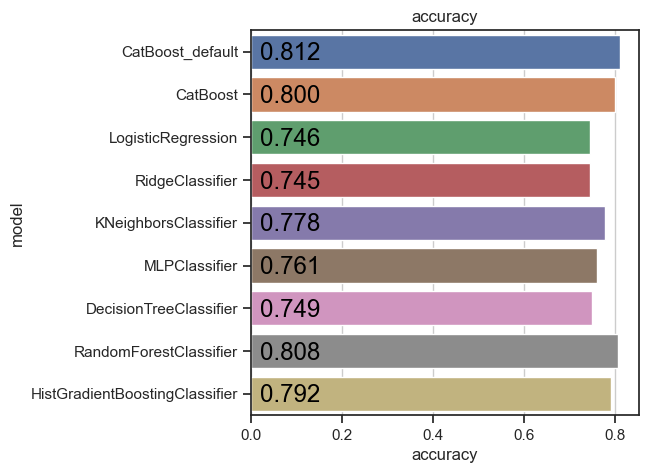

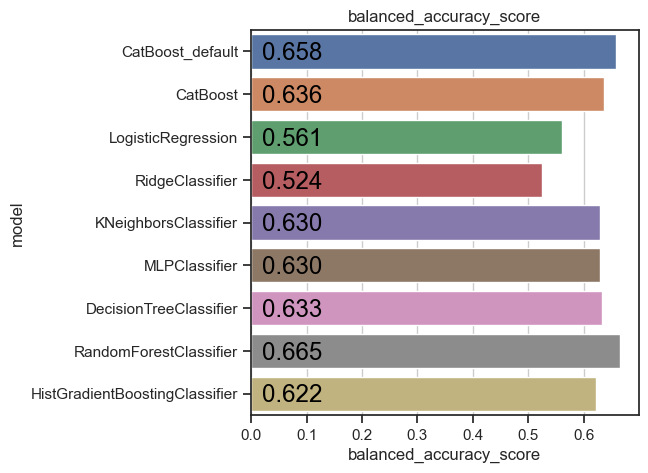

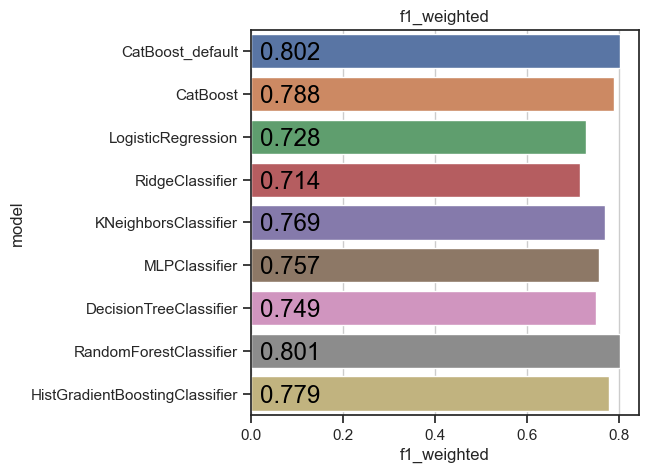

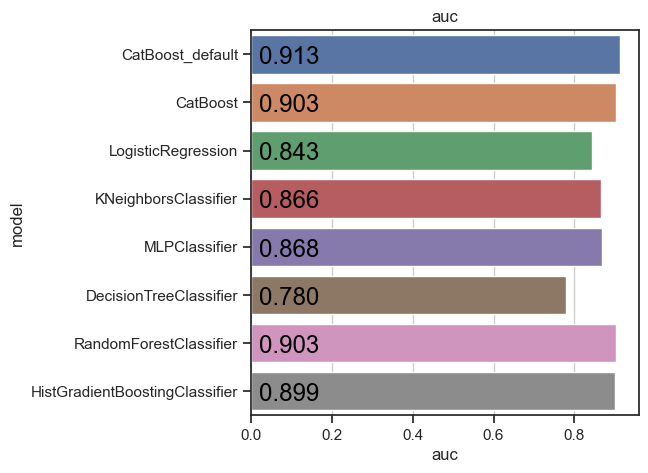

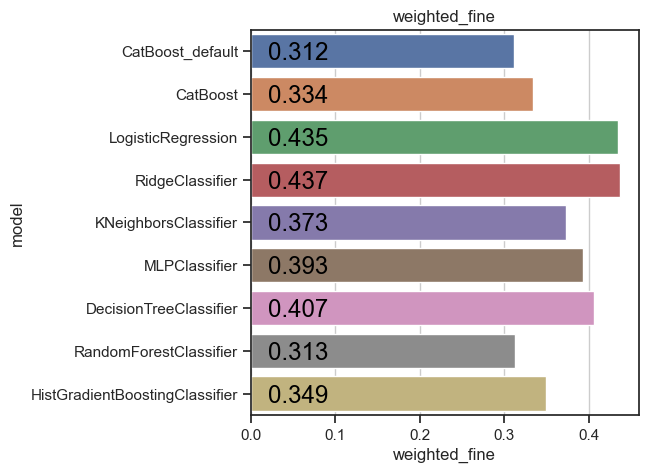

In [109]:
metrics_list = ['accuracy', 'balanced_accuracy_score', 'f1_weighted', 'auc', 'weighted_fine']

for metric in metrics_list:
    values = []
    types = []
    for description, train, test in training_log:
        if not description.endswith('cv'):
            val = getattr(test, metric)
            if val is None:
                continue
            values.append(val)
            types.append(description)
    
    info = pd.DataFrame({metric: values, 'model': types})
    plt.figure(figsize=(5, 5))
    ax = sns.barplot(data=info, y="model", x=metric, orient='h')
    for i, (tp, val) in enumerate(zip(types, values)):
        ax.text(0.02, i + 0.2, f'{val:.3f}', color='black', fontsize='xx-small')
    plt.title(metric)
    plt.show()

Current leaders are `CatBoost_default`, `RandomForestClassifier`, `HistGradientBoostingClassifier`.

Also, `RandomForestClassifier` is absolutely best on `balanced accuracy` and `weighted fine`.

# 7. Cross Validation

We will use a standard cross validation procedure with dividing our dataset into $5$ parts.

Our optimization metric will be `f1_weighted`, because it one of the most important metrics for our problem.

Let's find optimal hyperparameters for some models and fit new version of the model with best hyperparameters.

In [78]:
from sklearn.model_selection import GridSearchCV
from copy import deepcopy


def cv(name, model, parameters):
    final_model = deepcopy(model)
    
    cv = GridSearchCV(model, parameters, scoring='f1_weighted', verbose=4)
    cv.fit(X_full_t, y_full_t)
    
    print('start training best model')
    final_model.set_params(**cv.best_params_)
    final_model, train_metrics, test_metrics = train_model(f'{name}_cv', final_model, X_train_t, y_train_t, X_test_t, y_test_t)
    
    return cv.best_params_

## 7.1. LogisticRegression

In [69]:
parameters = {'C': np.logspace(-4, 1, 6)}
cv("LogisticRegression", LogisticRegression(max_iter=2000), parameters)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..........................C=0.0001;, score=0.703 total time=   1.1s
[CV 2/5] END ..........................C=0.0001;, score=0.700 total time=   1.5s
[CV 3/5] END ..........................C=0.0001;, score=0.696 total time=   1.3s
[CV 4/5] END ..........................C=0.0001;, score=0.699 total time=   1.1s
[CV 5/5] END ..........................C=0.0001;, score=0.710 total time=   0.9s
[CV 1/5] END ...........................C=0.001;, score=0.718 total time=   2.0s
[CV 2/5] END ...........................C=0.001;, score=0.718 total time=   1.9s
[CV 3/5] END ...........................C=0.001;, score=0.713 total time=   1.9s
[CV 4/5] END ...........................C=0.001;, score=0.717 total time=   2.2s
[CV 5/5] END ...........................C=0.001;, score=0.730 total time=   3.0s
[CV 1/5] END ............................C=0.01;, score=0.723 total time=   5.4s
[CV 2/5] END ............................C=0.01;,

{'C': 10.0}

## 7.2. RidgeClassifier

In [70]:
parameters = {'alpha': np.logspace(-4, 1, 6), 'class_weight': [None, 'balanced']}
cv("RidgeClassifier", RidgeClassifier(max_iter=2000), parameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...alpha=0.0001, class_weight=None;, score=0.714 total time=   0.3s
[CV 2/5] END ...alpha=0.0001, class_weight=None;, score=0.710 total time=   0.2s
[CV 3/5] END ...alpha=0.0001, class_weight=None;, score=0.708 total time=   0.4s
[CV 4/5] END ...alpha=0.0001, class_weight=None;, score=0.709 total time=   0.3s
[CV 5/5] END ...alpha=0.0001, class_weight=None;, score=0.720 total time=   0.3s
[CV 1/5] END alpha=0.0001, class_weight=balanced;, score=0.683 total time=   0.3s
[CV 2/5] END alpha=0.0001, class_weight=balanced;, score=0.671 total time=   0.2s
[CV 3/5] END alpha=0.0001, class_weight=balanced;, score=0.676 total time=   0.3s
[CV 4/5] END alpha=0.0001, class_weight=balanced;, score=0.677 total time=   0.3s
[CV 5/5] END alpha=0.0001, class_weight=balanced;, score=0.682 total time=   0.3s
[CV 1/5] END ....alpha=0.001, class_weight=None;, score=0.714 total time=   0.2s
[CV 2/5] END ....alpha=0.001, class_weight=

{'alpha': 1.0, 'class_weight': None}

## 7.3. KNeighborsClassifier

In [84]:
parameters = {'n_neighbors': [1, 5], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
cv("KNeighborsClassifier", KNeighborsClassifier(), parameters)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END n_neighbors=1, p=1, weights=uniform;, score=0.761 total time=  19.6s
[CV 2/5] END n_neighbors=1, p=1, weights=uniform;, score=0.751 total time=  19.3s
[CV 3/5] END n_neighbors=1, p=1, weights=uniform;, score=0.757 total time=  18.9s
[CV 4/5] END n_neighbors=1, p=1, weights=uniform;, score=0.753 total time=  18.7s
[CV 5/5] END n_neighbors=1, p=1, weights=uniform;, score=0.753 total time=  18.7s
[CV 1/5] END n_neighbors=1, p=1, weights=distance;, score=0.761 total time=  18.6s
[CV 2/5] END n_neighbors=1, p=1, weights=distance;, score=0.751 total time=  19.2s
[CV 3/5] END n_neighbors=1, p=1, weights=distance;, score=0.757 total time=  19.1s
[CV 4/5] END n_neighbors=1, p=1, weights=distance;, score=0.753 total time=  19.0s
[CV 5/5] END n_neighbors=1, p=1, weights=distance;, score=0.753 total time=  19.1s
[CV 1/5] END n_neighbors=1, p=2, weights=uniform;, score=0.757 total time=   1.4s
[CV 2/5] END n_neighbors=1, p=2, 

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

## 7.4. RandomForestClassifier

In [83]:
parameters = {'n_estimators': [10, 30, 100],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [5, 10, None]}
cv("RandomForestClassifier", RandomForestClassifier(), parameters)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.678 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.669 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.671 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.663 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.671 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=30;, score=0.686 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=30;, score=0.658 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=30;, score=0.678 total time=   0.6s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqr

[CV 5/5] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.798 total time=   5.3s
[CV 1/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=10;, score=0.786 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=10;, score=0.781 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=10;, score=0.787 total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=10;, score=0.782 total time=   0.4s
[CV 5/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=10;, score=0.783 total time=   0.4s
[CV 1/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=30;, score=0.799 total time=   1.2s
[CV 2/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=30;, score=0.790 total time=   1.1s
[CV 3/5] END criterion=gini, max_depth=None, max_features=log2, n_estimators=30;, score=0.794 t

[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.705 total time=   2.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.711 total time=   2.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.721 total time=   1.9s
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=10;, score=0.790 total time=   0.6s
[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=10;, score=0.784 total time=   0.6s
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=10;, score=0.789 total time=   0.6s
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=10;, score=0.781 total time=   0.6s
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=10;, score=0.791 total time=   0.6s
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estima

[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=30;, score=0.736 total time=   1.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.730 total time=   3.2s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.725 total time=   3.2s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.725 total time=   3.2s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.727 total time=   3.2s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.736 total time=   3.2s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=10;, score=0.716 total time=   0.2s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=10;, score=0.704 total time=   0.2s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, n_estimat

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 100}

## 7.5. HistGradientBoostingClassifier

In [86]:
parameters = {'learning_rate': [0.1, 0.3, 1.0], 'l2_regularization': [0.0, 0.1, 0.5, 1.0]}
cv("HistGradientBoostingClassifier", HistGradientBoostingClassifier(), parameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END l2_regularization=0.0, learning_rate=0.1;, score=0.784 total time=  16.2s
[CV 2/5] END l2_regularization=0.0, learning_rate=0.1;, score=0.778 total time=  16.1s
[CV 3/5] END l2_regularization=0.0, learning_rate=0.1;, score=0.783 total time=  14.8s
[CV 4/5] END l2_regularization=0.0, learning_rate=0.1;, score=0.777 total time=  15.2s
[CV 5/5] END l2_regularization=0.0, learning_rate=0.1;, score=0.784 total time=  15.3s
[CV 1/5] END l2_regularization=0.0, learning_rate=0.3;, score=0.792 total time=  12.4s
[CV 2/5] END l2_regularization=0.0, learning_rate=0.3;, score=0.790 total time=  12.2s
[CV 3/5] END l2_regularization=0.0, learning_rate=0.3;, score=0.787 total time=   9.5s
[CV 4/5] END l2_regularization=0.0, learning_rate=0.3;, score=0.772 total time=   4.7s
[CV 5/5] END l2_regularization=0.0, learning_rate=0.3;, score=0.786 total time=  13.7s
[CV 1/5] END l2_regularization=0.0, learning_rate=1.0;, score=0.718 t

{'l2_regularization': 1.0, 'learning_rate': 0.3}

In [125]:
parameters = {'depth': [6, 8]}
cv("CatBoost", CatBoostClassifier(iterations=1000, verbose=0), parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...........................depth=6;, score=0.793 total time=  15.7s
[CV 2/5] END ...........................depth=6;, score=0.788 total time=  16.0s
[CV 3/5] END ...........................depth=6;, score=0.791 total time=  16.5s
[CV 4/5] END ...........................depth=6;, score=0.785 total time=  15.4s
[CV 5/5] END ...........................depth=6;, score=0.790 total time=  16.5s
[CV 1/5] END ...........................depth=8;, score=0.801 total time=  34.2s
[CV 2/5] END ...........................depth=8;, score=0.797 total time=  34.4s
[CV 3/5] END ...........................depth=8;, score=0.798 total time=  32.8s
[CV 4/5] END ...........................depth=8;, score=0.796 total time=  32.2s
[CV 5/5] END ...........................depth=8;, score=0.795 total time=  32.1s
start training best model
Metrics of "CatBoost_cv (train)":
Accuracy: 0.878 | Balanced accuracy: 0.766 | F1(weighted): 0.873 | AUC

{'depth': 8}

## 7.6. Results

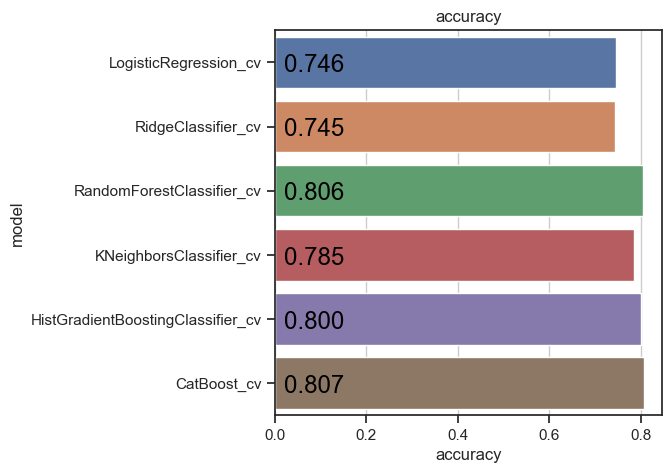

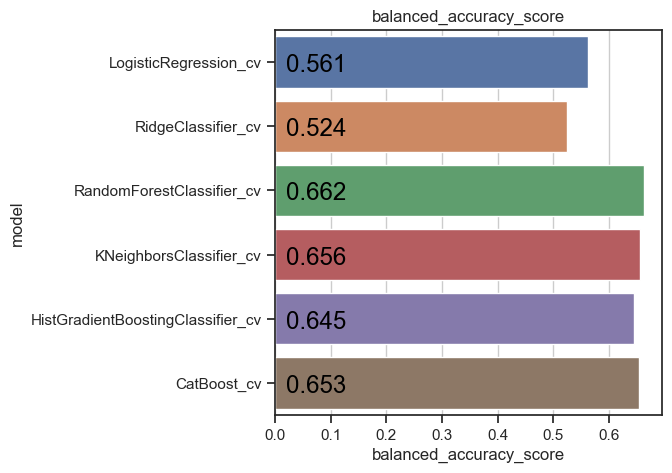

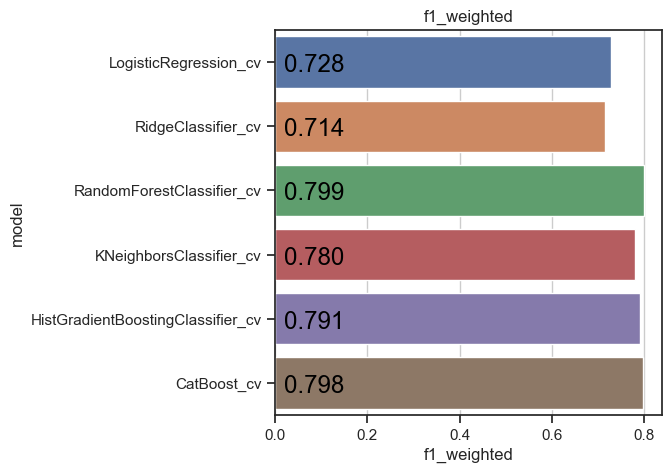

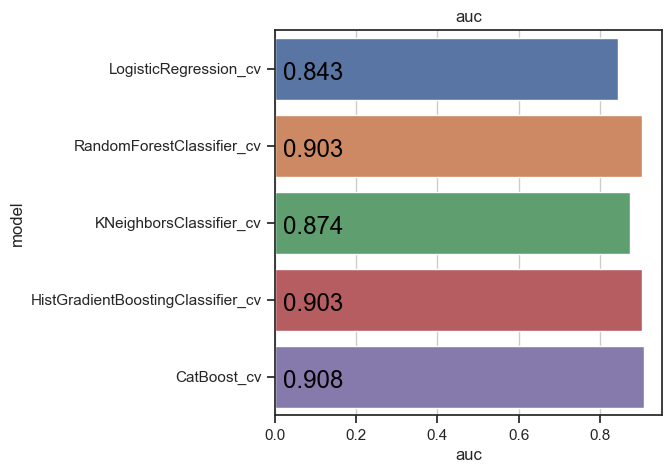

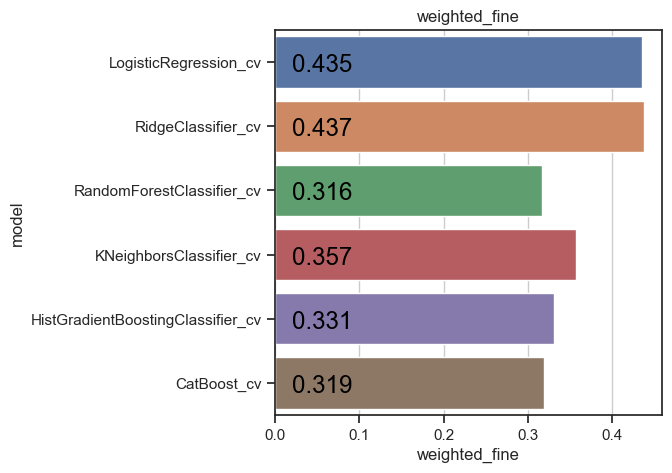

In [126]:
metrics_list = ['accuracy', 'balanced_accuracy_score', 'f1_weighted', 'auc', 'weighted_fine']

for metric in metrics_list:
    dt = {}
    for description, train, test in training_log:
        if description.endswith('cv'):
            val = getattr(test, metric)
            if val is None:
                continue
            dt[description] = val
            
    values = []
    types = []
    for tp, value in dt.items():
        values.append(value)
        types.append(tp)
    
    info = pd.DataFrame({metric: values, 'model': types})
    plt.figure(figsize=(5, 5))
    ax = sns.barplot(data=info, y="model", x=metric, orient='h')
    for i, (tp, val) in enumerate(zip(types, values)):
        ax.text(0.02, i + 0.15, f'{val:.3f}', color='black', fontsize='xx-small')
    plt.title(metric)
    plt.show()

In [127]:
models_list = ['LogisticRegression', 
               'RidgeClassifier',
               'RandomForestClassifier',
               'KNeighborsClassifier',
               'HistGradientBoostingClassifier',
               'CatBoost']

metrics_list = ['accuracy', 'balanced_accuracy_score', 'f1_weighted', 'auc', 'weighted_fine']

for model in models_list:
    print(model)
    for metric in metrics_list:
        before_cv = None
        after_cv = None
        for desc, train, test in training_log:
            if desc == model:
                before_cv = getattr(test, metric)
            if desc == f'{model}_cv':
                after_cv = getattr(test, metric)
        if before_cv is None or after_cv is None:
            continue
        print(f'{metric}: {before_cv:.3f} --> {after_cv:.3f}')
    print()

LogisticRegression
accuracy: 0.746 --> 0.746
balanced_accuracy_score: 0.561 --> 0.561
f1_weighted: 0.728 --> 0.728
auc: 0.843 --> 0.843
weighted_fine: 0.435 --> 0.435

RidgeClassifier
accuracy: 0.745 --> 0.745
balanced_accuracy_score: 0.524 --> 0.524
f1_weighted: 0.714 --> 0.714
weighted_fine: 0.437 --> 0.437

RandomForestClassifier
accuracy: 0.808 --> 0.806
balanced_accuracy_score: 0.665 --> 0.662
f1_weighted: 0.801 --> 0.799
auc: 0.903 --> 0.903
weighted_fine: 0.313 --> 0.316

KNeighborsClassifier
accuracy: 0.778 --> 0.785
balanced_accuracy_score: 0.630 --> 0.656
f1_weighted: 0.769 --> 0.780
auc: 0.866 --> 0.874
weighted_fine: 0.373 --> 0.357

HistGradientBoostingClassifier
accuracy: 0.792 --> 0.800
balanced_accuracy_score: 0.622 --> 0.645
f1_weighted: 0.779 --> 0.791
auc: 0.899 --> 0.903
weighted_fine: 0.349 --> 0.331

CatBoost
accuracy: 0.800 --> 0.807
balanced_accuracy_score: 0.636 --> 0.653
f1_weighted: 0.788 --> 0.798
auc: 0.903 --> 0.908
weighted_fine: 0.334 --> 0.319



Nothing changed for `LogisticRegression`, `RidgeClassifier`.

Nothing changed much for `RandomForestClassifier`.

We have a great upgrade for `KNeighborsClassifier`, `HistGradientBoostingClassifier`, `CatBoost`.

# 8. Conclusion

Exploratory analysis outlines that people who pay for water on a regular basis have access to more water in comparison ones who don't pay. Additionally, the probability of having functional waterpoint is higher when the water is paid regularly. Also, it was shown that there were quite a bit of outliers which have been removed.

Taking into consideration the data set has primarily categorical features, default catboost model has been chosen as a baseline to solve the problem. Surprisingly, the approach gave outstanding results as per competition rating list.

Concerning metrics, we believe that weighted fine is the most useful metric in practice, because it considers the mistake cost which is not the same for all types of mistakes in our case.

Some new features were derived and added (working_days, water_per_person, person_per_water, year, month, weekday). It's surprising that dropping features having approximately the same columns resulted in a bit decrease in quality.

Categorical features were encoded using `OneHotEncoder`, numeric features were scaled using scaling, robust to outliers. Also we added bins discretization for numeric features and categorical feature for geographic location of points.

For training we used all of sklearn classifiers and found, that in default setting the best classifiers are `CatBoost`, `RandomForestClassifier` and `HistGradientBoostingClassifier`. It is very surprizing, that `RandomForestClassifier` is absolutely best for metrics, considering class balance and weighted fine.

Using hyperparameters search with cross validation we upgraded models a bit, but nothing has changed much. It is very interesting finding, that `RandomForestClassifier` is the best for our problem according to our special metrics.

To sum up, our model can predict whether a waterpoint is functional or not with quite high accuracy, precision and recall. We assume that the model can be used for upkeep purposes to prevent pumps from break down.